### “Peak-Hour Congestion Analysis & Accident Pattern Detection for a Growing City”




📊 Required Visualizations
<br><br>
You must include at least 10 visualizations:
<br>
Line chart — hourly congestion trend
<br>
Heatmap — day vs hour congestion
<br>
Bar chart — congestion by road type
<br>
Boxplot — speed distribution by road type
<br>
Bar chart — accidents by severity
<br>
Time series plot — accidents across 24 hours
<br>
Pie chart — accident weather distribution
<br>
Scatter plot — GPS speed vs time
<br>
Cluster plot — accident or GPS clusters
<br>
Any additional chart you find useful<br><br>

In [192]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
traffic_vol = pd.read_csv(r"data/Metro_Interstate_Traffic_Volume.csv.gz") 
traffic_vol['date_time'] = pd.to_datetime(traffic_vol['date_time'], errors='coerce')
traffic_vol

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [62]:
accidents = pd.read_csv(r"data/traffic_accidents.csv")
accidents.head()

,crash_date,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,...,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,07/29/2023 01:00:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,13,7,7
1,08/13/2023 12:11:00 AM,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0,1,8
2,12/09/2021 10:30:00 AM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,10,5,12
3,08/09/2023 07:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,NONINCAPACITATING INJURY,5.0,0.0,0.0,5.0,0.0,0.0,19,4,8
4,08/19/2023 02:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,14,7,8


In [219]:
import os
os.chdir(r"C:/Users/USER/Desktop/microsoft/module 2")

In [220]:
gps_traces = pd.read_csv(r"data/go_track_trackspoints.csv")
gps_traces.head()

,id,latitude,longitude,track_id,time,speed
0,1.0,-10.939341,-37.062742,1.0,9/13/2014 7:24,19.210586
1,2.0,-10.939341,-37.062742,1.0,9/13/2014 7:24,30.848229
2,3.0,-10.939324,-37.062765,1.0,9/13/2014 7:24,13.560101
3,4.0,-10.939211,-37.062843,1.0,9/13/2014 7:24,19.766679
4,5.0,-10.938939,-37.062879,1.0,9/13/2014 7:24,25.807401


1️⃣ Data Cleaning & Preparation
<br><br>
Remove missing sensor readings.
<br>
Convert timestamps properly.
<br>
Detect and remove impossible values (speed = 300 km/h, vehicle_count negative).
<br>
Create additional columns:
<br>
hour, day_of_week, is_weekend
<br>
congestion_level based on vehicle_count + avg_speed
<br><br>

In [64]:
traffic_vol.dropna()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
126,Columbus Day,273.080,0.00,0.0,20,Clouds,few clouds,2012-10-08,455
1123,Veterans Day,288.120,0.00,0.0,87,Clear,sky is clear,2012-11-12,1000
1370,Thanksgiving Day,278.540,0.00,0.0,20,Mist,mist,2012-11-22,919
2360,Christmas Day,264.400,0.00,0.0,90,Clouds,overcast clouds,2012-12-25,803
2559,New Years Day,263.490,0.00,0.0,58,Clouds,broken clouds,2013-01-01,1439
...,...,...,...,...,...,...,...,...,...
44441,Memorial Day,299.487,0.00,0.0,24,Clouds,few clouds,2018-05-28,1088
45547,Independence Day,297.550,0.00,0.0,1,Mist,mist,2018-07-04,1021
46936,State Fair,289.020,0.00,0.0,1,Clear,sky is clear,2018-08-23,596
47330,Labor Day,292.430,0.25,0.0,1,Rain,light rain,2018-09-03,962


In [65]:
# traffic_vol['date_time'] = pd.to_datetime(traffic_vol['date_time'],format='%Y-%m-%d %H:%M:%S', errors = 'coerce')
# traffic_vol['date_time'].dtype
# traffic_vol

In [66]:
traffic_vol[traffic_vol['traffic_volume'] > 0].dropna()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
126,Columbus Day,273.080,0.00,0.0,20,Clouds,few clouds,2012-10-08,455
1123,Veterans Day,288.120,0.00,0.0,87,Clear,sky is clear,2012-11-12,1000
1370,Thanksgiving Day,278.540,0.00,0.0,20,Mist,mist,2012-11-22,919
2360,Christmas Day,264.400,0.00,0.0,90,Clouds,overcast clouds,2012-12-25,803
2559,New Years Day,263.490,0.00,0.0,58,Clouds,broken clouds,2013-01-01,1439
...,...,...,...,...,...,...,...,...,...
44441,Memorial Day,299.487,0.00,0.0,24,Clouds,few clouds,2018-05-28,1088
45547,Independence Day,297.550,0.00,0.0,1,Mist,mist,2018-07-04,1021
46936,State Fair,289.020,0.00,0.0,1,Clear,sky is clear,2018-08-23,596
47330,Labor Day,292.430,0.25,0.0,1,Rain,light rain,2018-09-03,962


In [67]:
traffic_vol['hour'] = traffic_vol['date_time'].dt.hour
traffic_vol['day_of_week'] = traffic_vol['date_time'].dt.day_name()
traffic_vol['is_weekend'] = (traffic_vol['day_of_week']=="Saturday") | (traffic_vol['day_of_week']=="Sunday")
traffic_vol

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,hour,day_of_week,is_weekend
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545,9,Tuesday,False
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516,10,Tuesday,False
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767,11,Tuesday,False
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026,12,Tuesday,False
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918,13,Tuesday,False
...,...,...,...,...,...,...,...,...,...,...,...,...
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543,19,Sunday,True
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781,20,Sunday,True
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159,21,Sunday,True
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450,22,Sunday,True


2️⃣ Analysis Tasks<br><br>
A. Peak Hour Congestion<br>

Find which hours and days experience the least traffic volume.
<br>
Check if traffic volume is worse on weekends or weekdays.
<br>


In [78]:
least = traffic_vol.sort_values(by='traffic_volume', ascending=True).tail()
df = pd.DataFrame()
df['date'] = least['date_time'].dt.date
df['hour'] = least['date_time'].dt.hour
df

,date,hour
5619,2013-04-30,7
22671,2016-04-22,7
22641,2016-04-21,7
22640,2016-04-21,7
31615,2017-03-09,16


In [94]:
weekday = traffic_vol[traffic_vol['is_weekend'] == False]
weekend = traffic_vol[traffic_vol['is_weekend'] == True]
weekday_load = float(weekday['traffic_volume'].apply("average"))
weekend_load = float(weekend['traffic_volume'].apply("average"))
if weekday_load>weekend_load:
    print("Weekdays were more busy")
else:
    print("Weekends were more busy")

Weekdays were more busy


B. Accident Hotspot Analysis
<br><br>
Identify which date have the highest accident frequency.
<br>
Check accident severity distribution.


In [96]:
accidents['crash_date'] = pd.to_datetime(accidents['crash_date'], errors = 'coerce')

C:\Users\USER\AppData\Local\Temp\ipykernel_15860\289138300.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  accidents['crash_date'] = pd.to_datetime(accidents['crash_date'], errors = 'coerce')


In [133]:
idx_date = accidents.set_index("crash_date")
rand = idx_date["traffic_control_device"].resample("D").size().reset_index()
no_accidents = idx_date["traffic_control_device"].resample("D").size().values.tolist()
max_accidents= max(no_accidents)
# max_accidents
result_data = rand[rand["traffic_control_device"] == max_accidents]
result_data.rename(columns={"traffic_control_device" : "No of Accidents"})

,crash_date,No of Accidents
2539,2020-02-14,155


In [142]:
rand = idx_date[["injuries_fatal","injuries_incapacitating","injuries_non_incapacitating","injuries_no_indication", "injuries_total"]].resample("D").sum().sort_values("injuries_total", ascending = False)
rand

,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_no_indication,injuries_total
crash_date,,,,,
2024-07-27,2.0,7.0,34.0,196.0,68.0
2024-09-01,0.0,4.0,38.0,226.0,68.0
2020-02-07,0.0,2.0,58.0,199.0,65.0
2024-05-18,1.0,3.0,42.0,188.0,63.0
2023-06-07,0.0,15.0,29.0,182.0,63.0
...,...,...,...,...,...
2013-04-07,0.0,0.0,0.0,0.0,0.0
2013-04-08,0.0,0.0,0.0,0.0,0.0
2013-04-09,0.0,0.0,0.0,0.0,0.0


C. Speed Pattern Analysis (GPS + Sensors)
<br><br>
Use GPS data to estimate “real speed trends” across the day.

In [146]:
gps_traces = gps_traces.dropna()
gps_traces

,id,latitude,longitude,track_id,time,speed
0,1.0,-10.939341,-37.062742,1.0,9/13/2014 7:24,19.210586
1,2.0,-10.939341,-37.062742,1.0,9/13/2014 7:24,30.848229
2,3.0,-10.939324,-37.062765,1.0,9/13/2014 7:24,13.560101
3,4.0,-10.939211,-37.062843,1.0,9/13/2014 7:24,19.766679
4,5.0,-10.938939,-37.062879,1.0,9/13/2014 7:24,25.807401
...,...,...,...,...,...,...
1462,1671.0,-10.916030,-37.051635,21.0,10/16/2014 13:09,30.051732
1463,1672.0,-10.916143,-37.051643,21.0,10/16/2014 13:09,30.173788
1464,1673.0,-10.916443,-37.051652,21.0,10/16/2014 13:09,1.153772
1465,1674.0,-10.916805,-37.051643,21.0,10/16/2014 13:09,0.843223


C:\Users\USER\AppData\Local\Temp\ipykernel_15860\2142741309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_traces['time'] = pd.to_datetime(gps_traces['time'], errors = 'coerce')
C:\Users\USER\AppData\Local\Temp\ipykernel_15860\2142741309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_traces['speed'] = pd.to_numeric(gps_traces['speed'], errors='coerce')


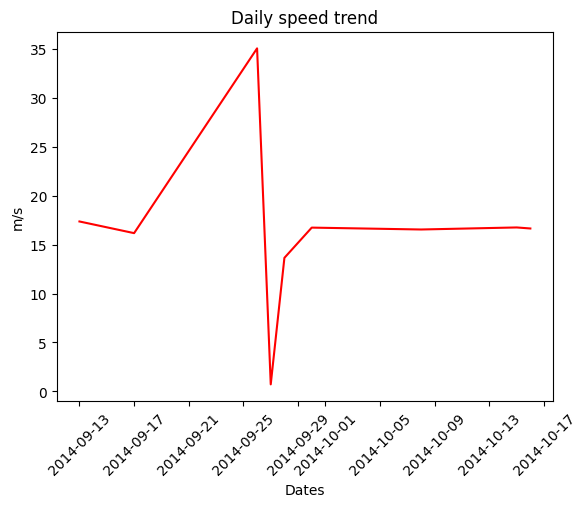

In [159]:
gps_traces['time'] = pd.to_datetime(gps_traces['time'], errors = 'coerce')
gps_traces['speed'] = pd.to_numeric(gps_traces['speed'], errors='coerce')
idx_date = gps_traces.set_index("time")
avg_speed_nan = idx_date['speed'].resample("D").mean()
avg_speed = avg_speed_nan.dropna()
fig,ax = plt.subplots()
ax.plot(avg_speed, color = 'red')
plt.title("Daily speed trend")
plt.xticks(rotation = 45)
plt.xlabel("Dates")
plt.ylabel("m/s")
# plt.savefig(r"plot/City Transportaion/Daily speed trend.png", dpi  = 100)
plt.show()

📊 Required Visualizations

You must produce at least 8 visuals:

Traffic volume hourly trend

Day vs hour traffic heatmap

Boxplot of speed/congestion by weather

Accident severity bar chart

Weather condition pie chart

24-hour accident trend line

Accident hotspot scatter/cluster plot

GPS trajectory plot (sampled points)




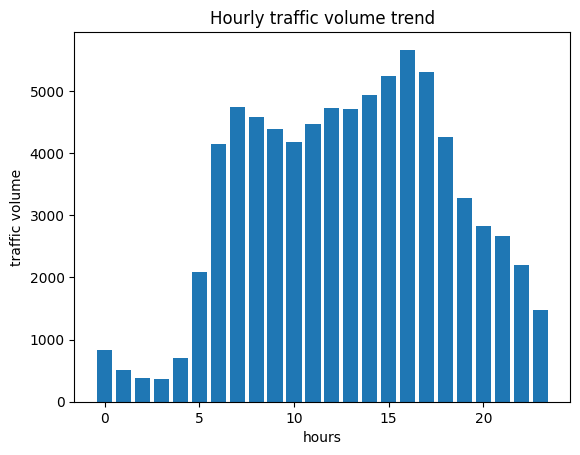

In [187]:
df = traffic_vol.groupby("hour")["traffic_volume"].mean().reset_index()
fig, ax = plt.subplots()
ax.bar(df["hour"], df['traffic_volume'])
plt.title("Hourly traffic volume trend")
plt.xlabel("hours")
plt.ylabel("traffic volume")
# plt.savefig(r"plot/City Transportaion/Hourly traffic volume trend.png", dpi  = 100)
plt.show()

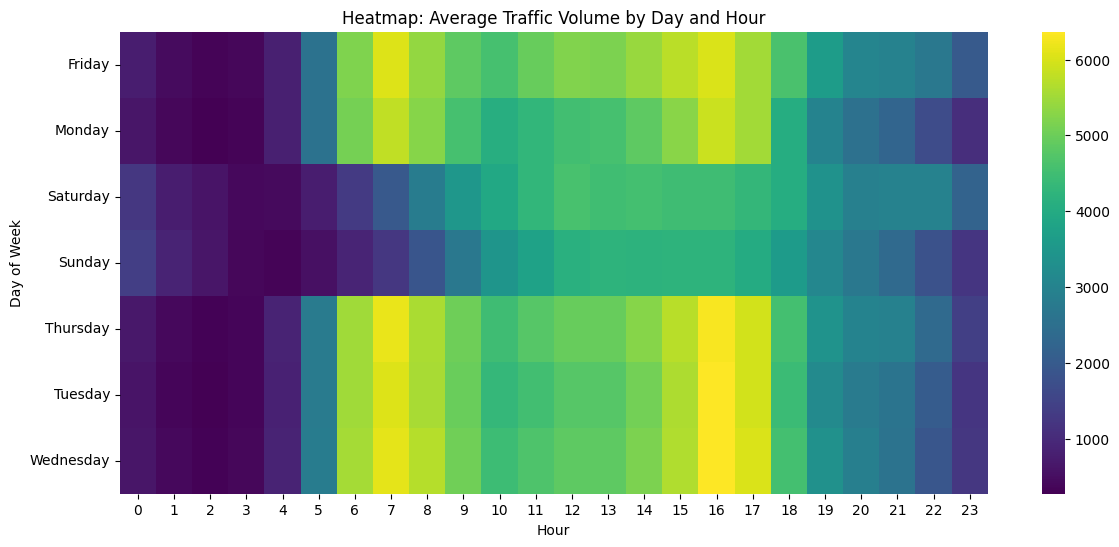

In [244]:
pivot = traffic_vol.pivot_table(
    index='day',
    columns='hour',
    values='traffic_volume',
    aggfunc='mean'
)

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap='viridis')
plt.title("Heatmap: Average Traffic Volume by Day and Hour")
plt.xlabel("Hour")
plt.ylabel("Day of Week")
# plt.savefig(r"plot/City Transportaion/heatmap day and hour.png", dpi = 100)
plt.show()

In [226]:
gps_traces['wheather condition'] = traffic_vol['weather_main']
gps_traces = gps_traces.dropna()
gps_traces

C:\Users\USER\AppData\Local\Temp\ipykernel_15860\989037725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gps_traces['wheather condition'] = traffic_vol['weather_main']


,id,latitude,longitude,track_id,time,speed,wheather condition
0,1.0,-10.939341,-37.062742,1.0,9/13/2014 7:24,19.210586,Clouds
1,2.0,-10.939341,-37.062742,1.0,9/13/2014 7:24,30.848229,Clouds
2,3.0,-10.939324,-37.062765,1.0,9/13/2014 7:24,13.560101,Clouds
3,4.0,-10.939211,-37.062843,1.0,9/13/2014 7:24,19.766679,Clouds
4,5.0,-10.938939,-37.062879,1.0,9/13/2014 7:24,25.807401,Clouds
...,...,...,...,...,...,...,...
1462,1671.0,-10.916030,-37.051635,21.0,10/16/2014 13:09,30.051732,Clouds
1463,1672.0,-10.916143,-37.051643,21.0,10/16/2014 13:09,30.173788,Clouds
1464,1673.0,-10.916443,-37.051652,21.0,10/16/2014 13:09,1.153772,Clouds
1465,1674.0,-10.916805,-37.051643,21.0,10/16/2014 13:09,0.843223,Clouds


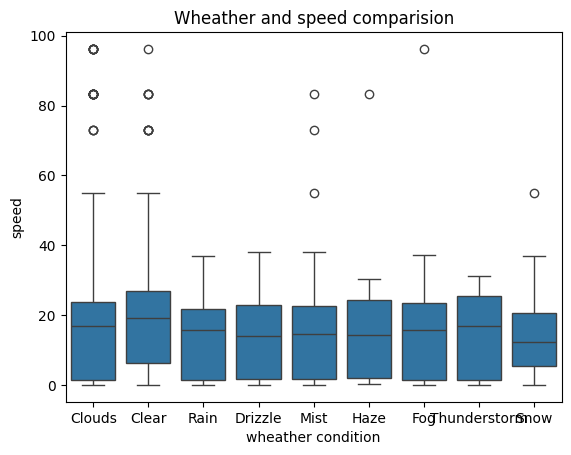

In [235]:
fig,ax = plt.subplots()
sns.boxplot(x= "wheather condition", y= "speed", data = gps_traces)
plt.title("Wheather and speed comparision")
plt.savefig(r"plot/City Transportaion/wheather and speed.png", dpi = 100)
plt.show()

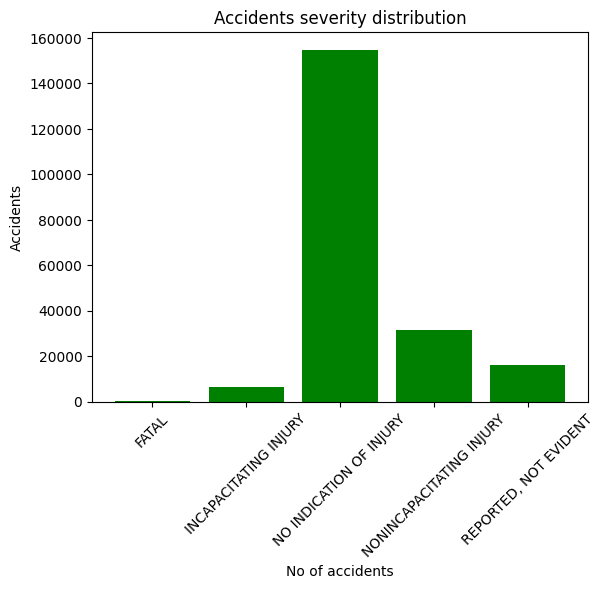

In [242]:
df = accidents.groupby(accidents['most_severe_injury']).size()
fig, ax = plt.subplots()
ax.bar(df.index, df.values, color = 'green')
plt.xlabel("No of accidents")
plt.ylabel("Accidents")
plt.title("Accidents severity distribution")
plt.xticks(rotation =45)
# plt.savefig(r"plot/City transportaion/accident severity distribution.png", dpi = 100)
plt.show()

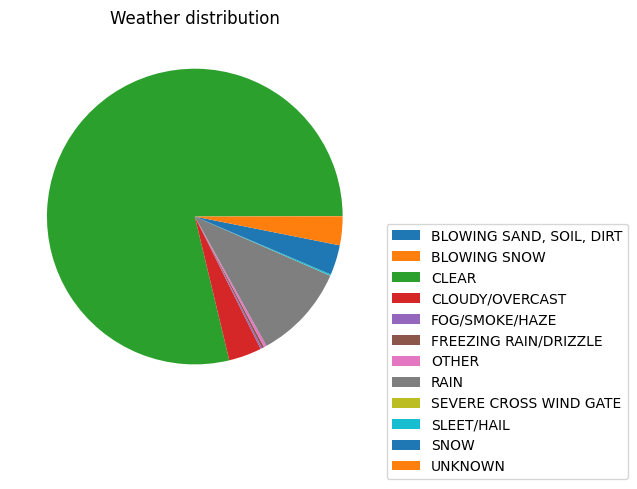

In [252]:
df = accidents.groupby(accidents['weather_condition']).size()
fig, ax = plt.subplots()
ax.pie(df)
plt.legend(labels=df.index, bbox_to_anchor= (1,0.5))
plt.title("Weather distribution")
plt.savefig(r"plot/City transportaion/Weather distribution.png", dpi = 100)
plt.show()

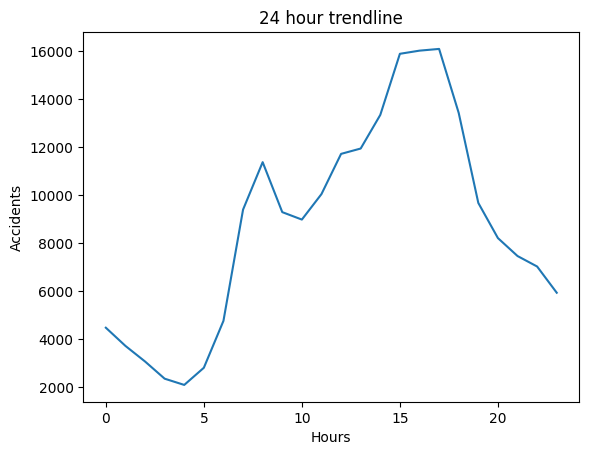

In [267]:
groups = accidents.groupby('crash_hour')["injuries_reported_not_evident"].size()
fig,ax = plt.subplots()
ax.plot(groups)
plt.xlabel("Hours")
plt.ylabel("Accidents")
plt.title("24 hour trendline")
# plt.savefig(r"plot/City Transportaion/hour trendline.png")
plt.show()

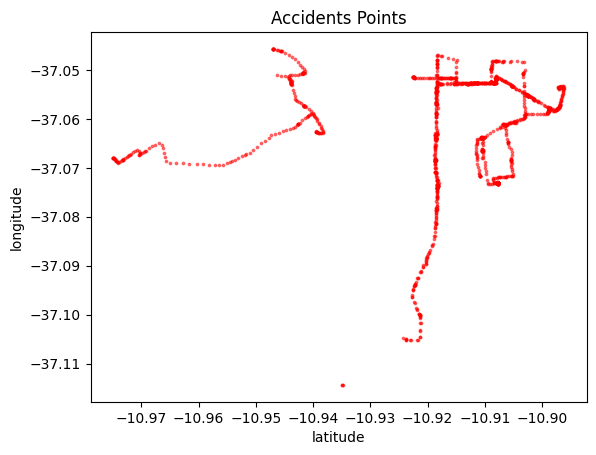

In [277]:
fig,ax = plt.subplots()
ax.scatter(gps_traces['latitude'], gps_traces['longitude'],
           s= 3, c= 'red', alpha=0.5)
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("Accidents Points")
# plt.savefig(r"plot/City Transportaion/accidents point.png")
plt.show()

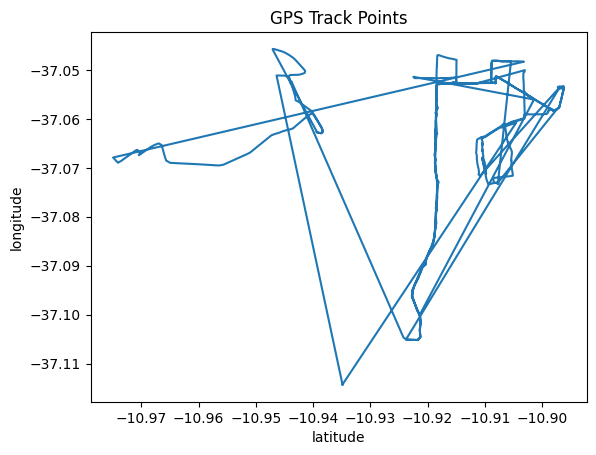

In [ ]:
fig,ax = plt.subplots()
ax.plot(gps_traces['latitude'], gps_traces['longitude'])
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.title("GPS Track Points")
# plt.savefig(r"plot/City Transportaion/gps track point.png")
plt.show()